In [16]:
# Imports

import pandas as pd
import numpy as np
import torch
from torch import nn

# Working with Datasets

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# XZ
import os
import pandas as pd
from torchvision.io import read_image

# Datasets

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Resize

# Visualisation

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from IPython.display import clear_output

In [17]:
def timofey_transform(digit: int):
    arr = np.zeros(10)
    arr[digit] = 1
    arr = torch.tensor(arr, dtype = torch.long, requires_grad=False)
    return arr

# download dataset

to_tensor = T.ToTensor()

dataset_train = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = True, download = True,
                            transform = to_tensor)
dataset_test = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = False, download = True,
                           transform = to_tensor)

# Подготовимся к BatchNormalization

In [18]:
mu = dataset_train.data.to(torch.float32).mean().item() / 255

std = dataset_train.data.to(torch.float32).std().item() / 255

normalize = T.Normalize(mu,std)

In [19]:
flow = T.Compose([to_tensor,normalize])

dataset_train = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = True, download = True,
                            transform = flow)
dataset_test = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = False, download = True,
                           transform = flow)

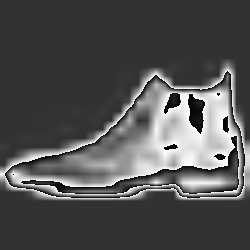

In [20]:
to_pil = T.ToPILImage()
#print(dataset_test[0][1])
resize = Resize([250,250])
to_pil(resize(dataset_test[0][0]))

In [21]:
idx2text = {0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"}

# Создадим DataLoaders

In [22]:
train_dataloader = DataLoader(dataset_train,batch_size = 8,shuffle = True, num_workers = 4)
test_dataloader = DataLoader(dataset_test,batch_size = 8,shuffle = True, num_workers = 4)

In [23]:
# Lets check into pic size
x_s, y_s = next(iter(train_dataloader))

# Опредялем Device

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Созданим арихитектуру сети

In [27]:
# Imports
from torch import nn

class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 x 28 x 28
        
        self.step_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, padding = 1), # 10 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2)) # 10 x 14 x 14
            
        self.step_2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 32, kernel_size = 3, padding = 1), # 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2)) # 32 x 8 x 8
            
        self.step_3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1), # 16 x 8 x 8
            nn.ReLU())
        
        self.step_4 = nn.Sequential(
            nn.Flatten()) # 16 x 7 x 7
            
        self.step_5 = nn.Sequential(
            nn.Linear(784,300),
            nn.ReLU(),
            nn.Linear(300, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.step_1(x)
        output = self.step_2(output)
        output = self.step_3(output)
        output = self.step_4(output)
        output = self.step_5(output)
        
        return output

In [29]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 x 28 x 28
        
        self.step_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, padding = 1), # 10 x 28 x 28
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2)) # 10 x 14 x 14
            
        self.step_2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 32, kernel_size = 3, padding = 1), # 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.2)) # 32 x 7 x 7
            
        self.step_5 = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(1568),
            nn.Linear(1568,10))
        
    def forward(self, x):
        output = self.step_1(x)
        output = self.step_2(output)
        output = self.step_5(output)
        
        return output

In [30]:
model = Model_2()
model.to(device)

Model_2(
  (step_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (step_2): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (step_5): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [31]:
from torch.optim import Adam
from tqdm import tqdm

optimizer = Adam(params = model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

In [32]:
def train_to_derive_input_output(model):
    model.train()
    
    for x,y in tqdm(train_dataloader,desc = "Training"):
        
        x.to(device)
        y.to(device)
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        y = y.resize(8,1)
        
        
        optimizer.zero_grad()
        
        output = model.forward(x) # res: torch.tensor.size(9)
        
        predicted_classes = output
        
        return x,y,output
    
x_s,y_s,output_s = train_to_derive_input_output(model)

def train(model):
    model.train()
    
    loss_per_epoch = []
    total_obj = 0
    total_correct = 0
    
    for x,y in tqdm(train_dataloader,desc = "Training"):
        
        x.to(device)
        y.to(device)
        x = x.to(torch.float32)
        y = y.to(torch.long)
        
        optimizer.zero_grad()
        
        output = model.forward(x) # res: torch.tensor.size(9)
        
        predicted_classes = torch.argmax(output, dim = 1)
        
        # return x,y,output
        
        # predicted_classes = torch.max(output,dim = 1)
        # predicted_classes = predicted_classes.to(torch.float32)
        
        # print(y.size(),output.size())
    
        loss = loss_fn(output,y)
        loss_ = loss.item()
        loss.backward()
        optimizer.step()
        loss_per_epoch.append(loss_)
        
        n_obj = len(y)
        n_correct = sum(predicted_classes == y)
        
        total_obj += n_obj
        total_correct += n_correct
        
    
    accuracy = total_correct / total_obj
    
    return loss_per_epoch,accuracy

#_,_,_ = train(model)

Training:   0%| | 0/7500/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Training:   0%| | 0/7500


In [628]:
x_s,y_s,ouput_s = train_to_derive_input_output(model)

Training:   0%|                                        | 0/7500 [00:02<?, ?it/s]


In [33]:
a,b = train(model)

Training: 100%|█| 7500/7


In [34]:
ll = []
acc = []
for epoch in range(6):
    a,b = train(model)
    a = sum(a)/ len(a)
    ll.append(a)
    acc.append(b)

Training: 100%|█| 7500/7
Training: 100%|█| 7500/7
Training: 100%|█| 7500/7
Training: 100%|█| 7500/7
Training: 100%|█| 7500/7
Training: 100%|█| 7500/7


In [35]:
acc

[tensor(0.7505),
 tensor(0.7540),
 tensor(0.7603),
 tensor(0.7678),
 tensor(0.7671),
 tensor(0.7694)]

In [75]:
def beautiful_evaluation(model):
    model.eval()
    y_true = []
    y_predicted = []
    uu = 0
    while uu <= 10:
        for x,y in tqdm(test_dataloader, desc = "Evaluation"):
            uu+= 1
            x.to(device)
            y.to(device)
            x = x.to(torch.float32)
            y = y.to(torch.long)

            output = model(x)
            predicted_classes = torch.argmax(output, dim = 1)
            
            y_true += [*y.tolist()]
            y_predicted += [*predicted_classes.tolist()]
            
    return y_true,y_predicted
            

In [76]:
y_true,y_predicted = beautiful_evaluation(model)

Evaluation: 100%|█| 1250


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1000
           1       0.96      0.98      0.97      1000
           2       0.74      0.75      0.75      1000
           3       0.84      0.84      0.84      1000
           4       0.60      0.90      0.72      1000
           5       0.97      0.95      0.96      1000
           6       0.63      0.48      0.54      1000
           7       0.88      0.98      0.93      1000
           8       0.95      0.95      0.95      1000
           9       0.98      0.91      0.94      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



Text(0.5, 23.52222222222222, 'Model output')

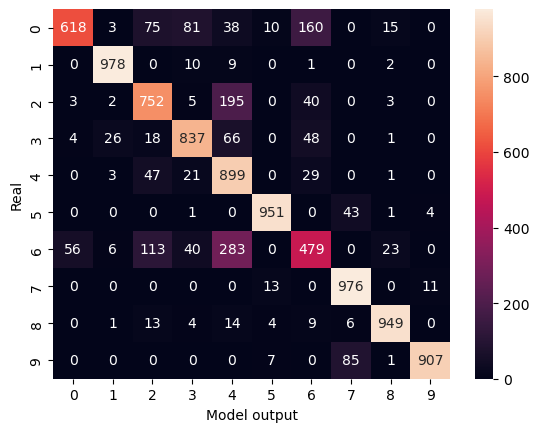

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_true,y_predicted), annot = True, fmt = '')
plt.ylabel("Real")
plt.xlabel("Model output")